In [120]:
from utils import sars2_genome_info, get_parent, add_mut_accumulation_attr
from utils_plotting import get_color_palette, convert_linege_names, get_linear_reg_stats
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd
from collections import Counter
from scipy import stats
import requests
import random
import math
import json
import re

## Table 1: Accumulation of nonsynonymous mutations across the entire genome

#### Table 1 gives the same information as Figure 1 except for every gene in the SARS-CoV-2 genome

##### The accumulation of mutations in different regions of the genome is counted and the slope of mutation accumulation over time is used to give a rate of mutation accumulation

##### Mutation accumulation is then compared to logistic growth rate and the R-value of this correlation and p-value of that R-value are reported

#### This notebook completes the analysis for Table 1.

Import the tree and convert to Bio Phylo format. This is a time-resolved phylogeny built from 9544 SARS-CoV-2 genomes sampled between December 2019 and May 15, 2021. The tree can be viewed at https://nextstrain.org/groups/blab/ncov/adaptive-evolution/2021-05-15

In [2]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_2021-05-15.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

Get information about genome position and length of each gene 

In [3]:
reference_gene_locations, reference_gene_codon, gene_lengths_aa = sars2_genome_info()

Add an attribute to each node that gives the total number of mutations (synonymous SNPs, or nonsynonymous SNPs plus deletions) accumulated between the tree root and that node (including mutations on the node). 

In [4]:
tree = add_mut_accumulation_attr(tree)

List all genes

In [5]:
all_genes = ['Nsp1', 'Nsp2', 'Nsp3', 'Nsp4', 'Nsp5', 'Nsp6', 'Nsp7', 'Nsp8', 'Nsp9', 
             'Nsp10', 'RdRp', 'Nsp13', 'Nsp14', 'Nsp15', 'Nsp16', 'S1', 'S2', 'ORF3a', 'E', 
             'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9b']


Now make a table that includes EVERY gene. Table will include rate of mutation accumulation and stats for the correlation between mutation accumulation and logistic growth rate

In [6]:
all_genes_information = []

# only look at internal nodes
for node in tree.find_clades(terminal=False):

    # only nodes within 6 weeks of May 15 have logisitic growth rates
    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        # get inferred node date
        date = node.node_attrs["num_date"]["value"]
        
        # get emerging lineage assignment of node 
        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']
            emerging_lineage = convert_linege_names(emerging_lineage)

        # make tidy df for seaborn plotting
        for r in all_genes:
            # name of attr for nonsyn mutations in this gene
            accumulation_attr = f'{r.lower()}_accumulation'
            # there are no synonymous deletions, but S1 deletions will be stored with S1_syn mut information-> these will not be plotted
            all_genes_information.append({'clade': node.name, 'date': date,
                                     'emerging_lineage': emerging_lineage,
                                     'mut_location': r, 
                                     'num_muts': node.node_attrs[accumulation_attr],  
                                     'muts_per_codon': node.node_attrs[accumulation_attr]/gene_lengths_aa[r],
                                     'logistic_growth': logistic_growth})


# make list into dataframe
all_genes_df = pd.DataFrame(all_genes_information)

In [25]:
def all_genes_table(data_files):
    """
    Make table listing rate of mutation accumulation in each gene, 
    the R-value for the correlation between mutation accumulation and logistic growth rate, 
    and the p-value for this r-value compared to randomized trees
    """
    # initialize dataframe to store information from all .json files where randomized data is stored
    expected_df = pd.DataFrame(columns = ['data', 'iteration', 'gene', 'nonsyn_syn', 'r_value'])
    
    # read in all randomization R values
    for data_file in data_files:
        with open(data_file) as json_file:
            data = json.load(json_file)
            df = pd.DataFrame(data['growth_rate_stats'])
            expected_df = pd.concat([expected_df, df])
    
    table1_stats = []
    
    for r in all_genes:
        # get expected r-values for this gene
        expected_gene_data = expected_df[(expected_df['gene']==r) & (expected_df['nonsyn_syn']=='nonsyn')]
        
        num_iterations = len(expected_gene_data)
        
        # get the mutation accumulation rate for this gene
        mut_accumulation_rate, rv = get_linear_reg_stats(all_genes_df, r, 
                                              'date', 'muts_per_codon')
        
        # get the empirical r-value for the correlation between mut accumulation and logisitic growth rate
        s, observed_r_value = get_linear_reg_stats(all_genes_df, r, 
                                              'logistic_growth', 'muts_per_codon')
        
        # find the p-value 
        pvalue= len(expected_gene_data[expected_gene_data['r_value']>observed_r_value])/num_iterations

        
        # make pvalue legible for table
        if pvalue<0.005:
            pvalue = '<0.005'
        else:
            pvalue = round(pvalue, 2)
        
        table1_stats.append({'gene': r, 
                             'mut_accumulation_rate': f'{format(mut_accumulation_rate, "10.2E")}', 
                            'mut_growth_r_value':observed_r_value, 
                             'pvalue': pvalue})
        
    table1 = pd.DataFrame(table1_stats)
        
    return table1

In [26]:
all_genes_table(['growth_rate_stats/growth_stats_50it.json', 
            'growth_rate_stats/growth_stats_50itmore.json', 
            'growth_rate_stats/growth_stats_200its.json', 
            'growth_rate_stats/growth_stats_400its.json', 
            'growth_rate_stats/growth_stats_300its.json',
                 'growth_rate_stats/growth_stats-supp_100its.json', 
                  'growth_rate_stats/growth_stats-supp_150its.json', 
                  'growth_rate_stats/growth_stats-supp_250its.json', 
                  'growth_rate_stats/growth_stats-supp_300its.json', 
                  'growth_rate_stats/growth_stats-supp_200itsmore.json', 
                 'growth_rate_stats/growth_stats-other_orfs_10its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_100its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_200its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_300its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_250its.json',
                 'growth_rate_stats/growth_stats-other_orfs_150its.json',
                 'growth_rate_stats/growth_stats-other_nsps_10its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_100its.json',
                 'growth_rate_stats/growth_stats-other_nsps_200its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_300its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_250its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_150its.json'])


,gene,mut_accumulation_rate,mut_growth_r_value,pvalue
0,Nsp1,1.00E-04,0.05,0.43
1,Nsp2,2.00E-04,-0.10,0.88
2,Nsp3,1.30E-03,0.30,0.08
3,Nsp4,8.00E-04,0.28,0.06
4,Nsp5,5.00E-04,-0.09,0.83
5,Nsp6,3.40E-03,0.35,0.01
6,Nsp7,3.00E-04,-0.42,1
7,Nsp8,3.00E-04,0.04,0.44
8,Nsp9,7.00E-04,0.06,0.3
9,Nsp10,1.00E-04,-0.05,0.81


Plot Table 1 as a scatterplot for easier visualization

In [174]:
def scatterplot_table1(data_files, filename=None):
    
    fig, ax = plt.subplots(figsize=(6,5))
    plt.tight_layout()
    
    cmap = {'Nsp1':'#fff6c4', 'Nsp2':'#fff09d', 'Nsp3':'#ffe662', 'Nsp4':"#ffc59c", 
            'Nsp5':'#ffd700', 'Nsp6':"#c35100", 'Nsp7':'#d8b600', 'Nsp8':'#eb4000', 'Nsp9':'#c43500', 
             'Nsp10':'#eb6200', 'RdRp':"#ff8c3a", 'Nsp13':'#ffae75', 'Nsp14':'#ff703b', 
            'Nsp15':'#ff7e4e', 'Nsp16':'#ffa989', 'S1':"#4770eb", 
            'S2':'#1238aa', 'ORF3a':'#5c3d6f', 'E':'#307358', 
             'M':'#a2d9c3', 'ORF6':'#67447c', 'ORF7a':'#7c5295', 
            'ORF7b':'#ab8abf', 'ORF8':'#d0bddb', 'N':'#419D78', 'ORF9b':'#ebe3f0'}
    
    table1 = all_genes_table(data_files)
    # change the legible <0.005 to 0.005 so it can be converted to a float
    table1['pvalue'] = np.where(table1['pvalue']=='<0.005', 0.005, table1['pvalue'])
    table1['pvalue'] = table1['pvalue'].astype(float)
    # add a binary sig or not column
    table1['sig'] = np.where(table1['pvalue']<=0.01, True,False)
    
    table1['mut_accumulation_rate'] = table1['mut_accumulation_rate'].astype(float)

    sns.scatterplot(x='mut_accumulation_rate', y='mut_growth_r_value', hue='gene',  palette=cmap,
                    s=100, 
                    style='sig', style_order = [True,False],
                    data=table1, legend=False)
    
    # make x tick labels more legible
    ax.set_xticks([0.0000, 0.0050, 0.0100, 0.0150])
    ax.set_xticklabels([r'0 x $10^{-3}$', r'5 x $10^{-3}$', r'10 x $10^{-3}$', r'15 x $10^{-3}$'], 
                       fontsize=12)
    
    # make legend only for significance
    handles= [Line2D([0], [0], marker='o', color='w', markerfacecolor='black', label='True', markersize=8), 
              Line2D([0], [0], marker='X', color='w', markerfacecolor='black', label='False', markersize=8)]
    plt.legend(title='Significant $r$', handles=handles)

    
    sns.despine(left=False, bottom=False)
    
    ax.set_ylabel('Clade growth correlation $r$', fontsize = 12)
    ax.set_xlabel('Nonsynonymous evolutionary rate (subs per codon per year)', fontsize = 12)
    
    plt.setp(ax.get_yticklabels(), fontsize=12)
    
    # only label some (important and where there is room) so labels are legible
    genes_to_label = ['Nsp2', 'Nsp6', 'Nsp7',   
             'RdRp', 'Nsp16', 'S1', 'S2', 'ORF3a', 'E', 
             'M', 'ORF7a', 'ORF8', 'N']
    for k,v in table1.iterrows():
        if v['gene'] in genes_to_label:
            ax.text(v['mut_accumulation_rate']+0.0004, v['mut_growth_r_value']-0.01, str(v['gene']))
            
    if filename: 
        fig.savefig(filename, dpi=300, bbox_inches='tight')

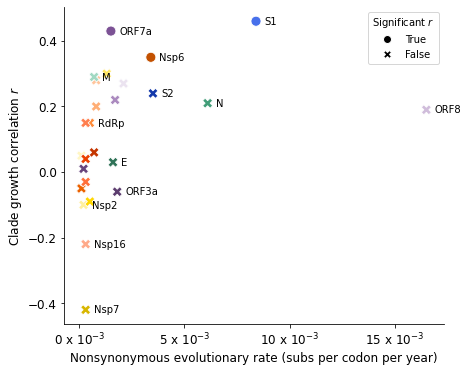

In [173]:
scatterplot_table1(['growth_rate_stats/growth_stats_50it.json', 
            'growth_rate_stats/growth_stats_50itmore.json', 
            'growth_rate_stats/growth_stats_200its.json', 
            'growth_rate_stats/growth_stats_400its.json', 
            'growth_rate_stats/growth_stats_300its.json',
                 'growth_rate_stats/growth_stats-supp_100its.json', 
                  'growth_rate_stats/growth_stats-supp_150its.json', 
                  'growth_rate_stats/growth_stats-supp_250its.json', 
                  'growth_rate_stats/growth_stats-supp_300its.json', 
                  'growth_rate_stats/growth_stats-supp_200itsmore.json', 
                 'growth_rate_stats/growth_stats-other_orfs_10its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_100its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_200its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_300its.json', 
                 'growth_rate_stats/growth_stats-other_orfs_250its.json',
                 'growth_rate_stats/growth_stats-other_orfs_150its.json',
                 'growth_rate_stats/growth_stats-other_nsps_10its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_100its.json',
                 'growth_rate_stats/growth_stats-other_nsps_200its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_300its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_250its.json', 
                 'growth_rate_stats/growth_stats-other_nsps_150its.json'], filename='plots/table1_supp')